In [17]:
%load_ext zipline

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline


c:\users\michael.li\appdata\local\continuum\miniconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
c:\users\michael.li\appdata\local\continuum\miniconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[2018-09-16 10:58:52.372030] INFO: Performance: after split: asset: Equity(8 [AAPL]), amount: 130417, cost_basis: 76.68, last_sale_price: 645.57
[2018-09-16 10:58:52.373019] INFO: Performance: returning cash: 0.0
[2018-09-16 10:58:57.555017] INFO: zipline.finance.metrics.tracker: Simulated 1007 trading days
first open: 2014-01-02 14:31:00+00:00
last close: 2017-12-29 21:00:00+00:00


c:\users\michael.li\appdata\local\continuum\miniconda3\envs\env_zipline\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)
c:\users\michael.li\appdata\local\continuum\miniconda3\envs\env_zipline\lib\site-packages\pyfolio\tears.py:200: UserWarning: The latest version of pyfolio requires users to supply benchmark returns. Your current tearsheets will not include plots and analyses that require a benchmark. In the future, please pass benchmark_rets, or pass None to silence this warning.
  warnings.warn(BENCHMARK_RETS_WARNING)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,32.08,2015-02-23,2016-05-12,2017-02-13,516
1,10.93,2014-11-26,2015-01-16,2015-02-04,51
2,10.33,2014-01-15,2014-01-30,2014-04-24,72
3,8.86,2017-05-12,2017-06-16,2017-08-02,59
4,8.23,2017-09-01,2017-09-25,2017-10-30,42


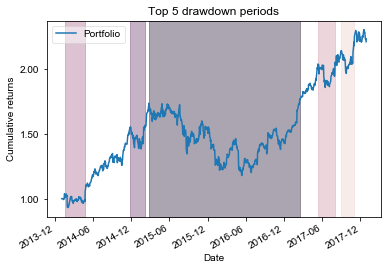

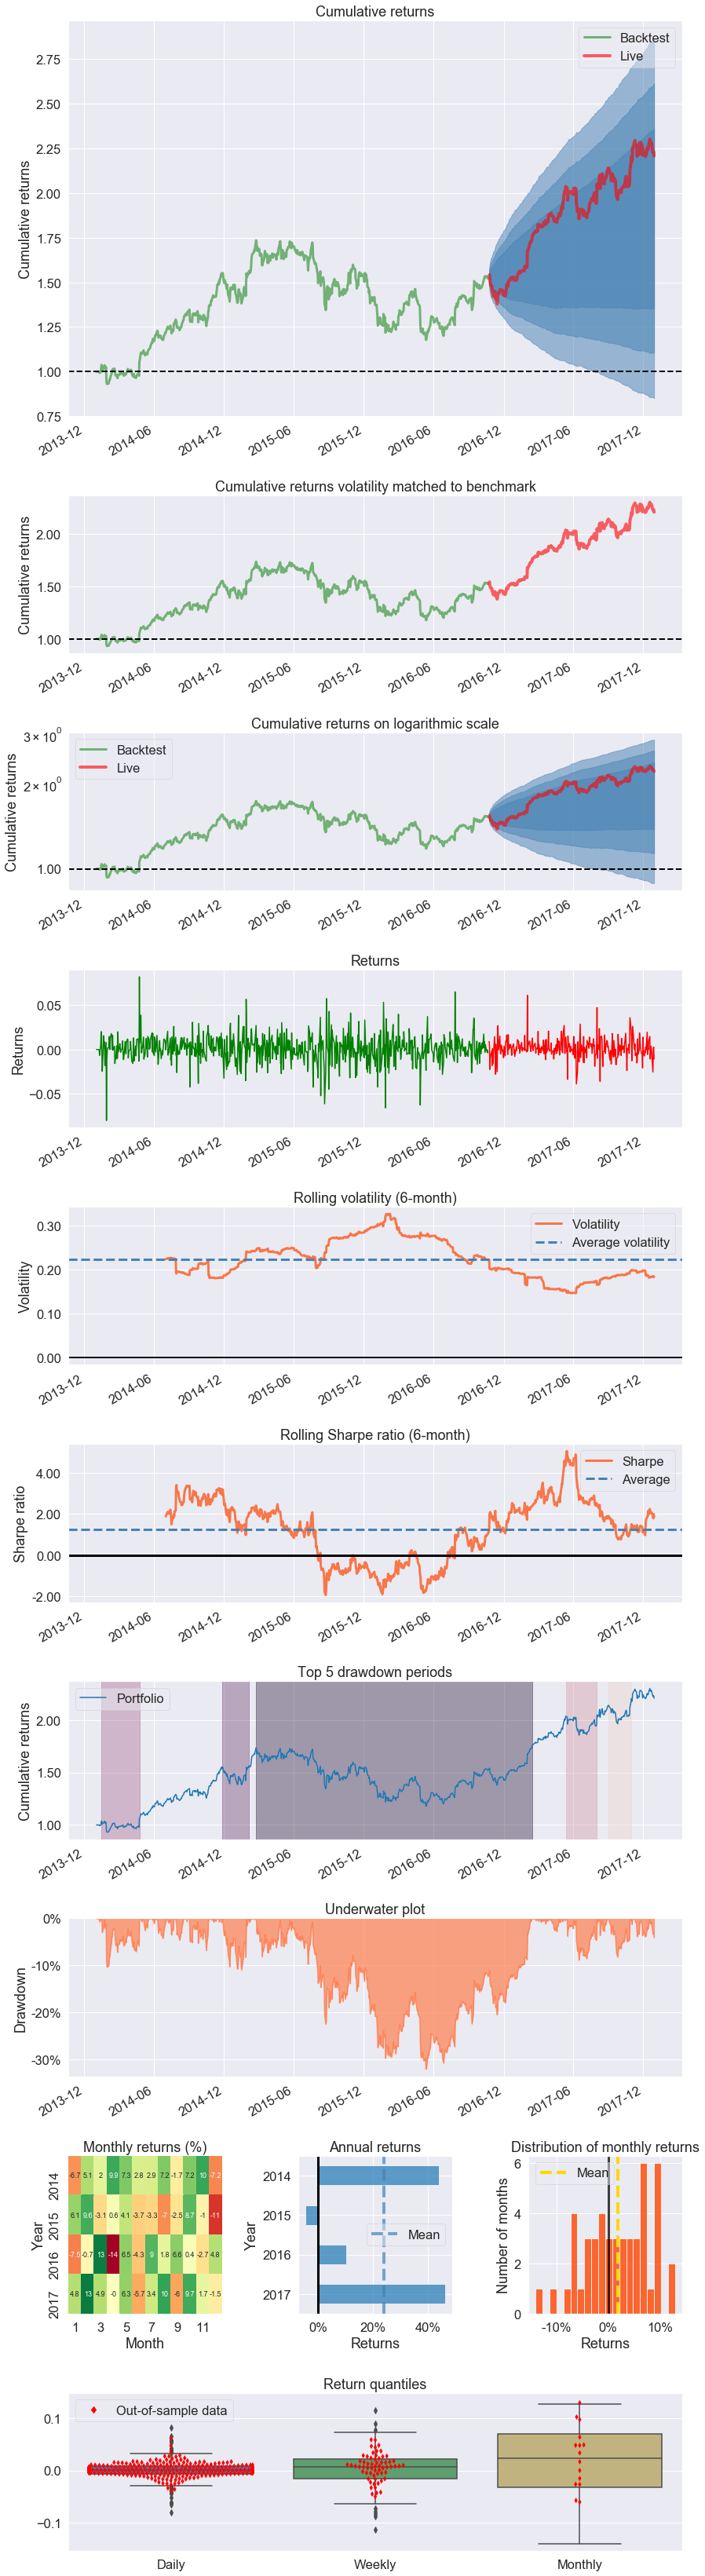

Stress Events,mean,min,max
Apr14,0.46%,-1.57%,8.20%
Oct14,0.31%,-1.56%,2.72%
Fall2015,-0.14%,-6.12%,5.74%
New Normal,0.09%,-7.99%,8.20%


AttributeError: 'NoneType' object has no attribute 'copy'

In [18]:
%%zipline --start 2014-1-1 --end 2018-1-1
from zipline.api import order_target,record,symbol
import matplotlib.pyplot as plt
import pyfolio as pf
import sys
#import logbook
import numpy as np
from datetime import datetime
import pytz

from zipline.algorithm import TradingAlgorithm
#from zipline.utils.factory import load_from_yahoo
from zipline.finance import commission

#['AMD', 'CERN', 'COST', 'DELL', 'GPS', 'INTC', 'MMM']
STOCKS = ['AAPL']


# On-Line Portfolio Moving Average Reversion

# More info can be found in the corresponding paper:
# http://icml.cc/2012/papers/168.pdf
def initialize(algo, eps=1, window_length=5):
    algo.stocks = STOCKS
    algo.sids = [algo.symbol(symbol) for symbol in algo.stocks]
    algo.m = len(algo.stocks)
    algo.price = {}
    algo.b_t = np.ones(algo.m) / algo.m
    algo.last_desired_port = np.ones(algo.m) / algo.m
    algo.eps = eps
    algo.init = True
    algo.days = 0
    algo.window_length = window_length

    algo.set_commission(commission.PerShare(cost=0))


def handle_data(algo, data):
    algo.days += 1
    if algo.days < algo.window_length:
        return

    if algo.init:
        rebalance_portfolio(algo, data, algo.b_t)
        algo.init = False
        return

    m = algo.m

    x_tilde = np.zeros(m)
    b = np.zeros(m)

    # find relative moving average price for each asset
    mavgs = data.history(algo.sids, 'price', algo.window_length, '1d').mean()
    for i, sid in enumerate(algo.sids):
        price = data.current(sid, "price")
        # Relative mean deviation
        x_tilde[i] = mavgs[sid] / price

    ###########################
    # Inside of OLMAR (algo 2)
    x_bar = x_tilde.mean()

    # market relative deviation
    mark_rel_dev = x_tilde - x_bar

    # Expected return with current portfolio
    exp_return = np.dot(algo.b_t, x_tilde)
    weight = algo.eps - exp_return
    variability = (np.linalg.norm(mark_rel_dev)) ** 2

    # test for divide-by-zero case
    if variability == 0.0:
        step_size = 0
    else:
        step_size = max(0, weight / variability)

    b = algo.b_t + step_size * mark_rel_dev
    b_norm = simplex_projection(b)
    np.testing.assert_almost_equal(b_norm.sum(), 1)

    rebalance_portfolio(algo, data, b_norm)

    # update portfolio
    algo.b_t = b_norm


def rebalance_portfolio(algo, data, desired_port):
    # rebalance portfolio
    desired_amount = np.zeros_like(desired_port)
    current_amount = np.zeros_like(desired_port)
    prices = np.zeros_like(desired_port)

    if algo.init:
        positions_value = algo.portfolio.starting_cash
    else:
        positions_value = algo.portfolio.positions_value + \
            algo.portfolio.cash

    for i, sid in enumerate(algo.sids):
        current_amount[i] = algo.portfolio.positions[sid].amount
        prices[i] = data.current(sid, "price")

    desired_amount = np.round(desired_port * positions_value / prices)

    algo.last_desired_port = desired_port
    diff_amount = desired_amount - current_amount
    
    #print("++++++++++++++++++++++++++++")

    for i, sid in enumerate(algo.sids):
        algo.order(sid, diff_amount[i])


def simplex_projection(v, b=1):
    """Projection vectors to the simplex domain
    Implemented according to the paper: Efficient projections onto the
    l1-ball for learning in high dimensions, John Duchi, et al. ICML 2008.
    Implementation Time: 2011 June 17 by Bin@libin AT pmail.ntu.edu.sg
    Optimization Problem: min_{w}\| w - v \|_{2}^{2}
    s.t. sum_{i=1}^{m}=z, w_{i}\geq 0
    Input: A vector v \in R^{m}, and a scalar z > 0 (default=1)
    Output: Projection vector w
    :Example:
    >>> proj = simplex_projection([.4 ,.3, -.4, .5])
    >>> print(proj)
    array([ 0.33333333, 0.23333333, 0. , 0.43333333])
    >>> print(proj.sum())
    1.0
    Original matlab implementation: John Duchi (jduchi@cs.berkeley.edu)
    Python-port: Copyright 2013 by Thomas Wiecki (thomas.wiecki@gmail.com).
    """

    v = np.asarray(v)
    p = len(v)

    # Sort v into u in descending order
    v = (v > 0) * v
    u = np.sort(v)[::-1]
    sv = np.cumsum(u)

    rho = np.where(u > (sv - b) / np.arange(1, p + 1))[0][-1]
    theta = np.max([0, (sv[rho] - b) / (rho + 1)])
    w = (v - theta)
    w[w < 0] = 0
    return w

def analyze(context,perf):
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    pf.plot_drawdown_periods(returns, top=5).set_xlabel('Date')
    pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions,
                          live_start_date='2016-10-22', round_trips=True)
    
# start = datetime(2004, 1, 1, 0, 0, 0, 0, pytz.utc)
# end = datetime(2010, 1, 1, 0, 0, 0, 0, pytz.utc)

# Load price data from yahoo.
# data = load_from_yahoo(stocks=STOCKS, indexes={}, start=start, end=end)
# data = data.dropna()

# Create and run the algorithm.
# olmar = TradingAlgorithm(handle_data=handle_data, initialize=initialize)
# results = olmar.run(data)


NameError: name 'logbook' is not defined